# Notebook for clustering SalishSeaCast data - PRODIGY Field School May 2024

### We will use the sklearn-som package. In order to install it, follow the steps below:


#### 1) Extract the rar file provided to a directory (some-dir)
#### 2) On the python terminal, type the following command: `pip install C:/some-dir/sklearn_som-1.1.0-py3-none-any.whl`

## What is clustering?

### From this
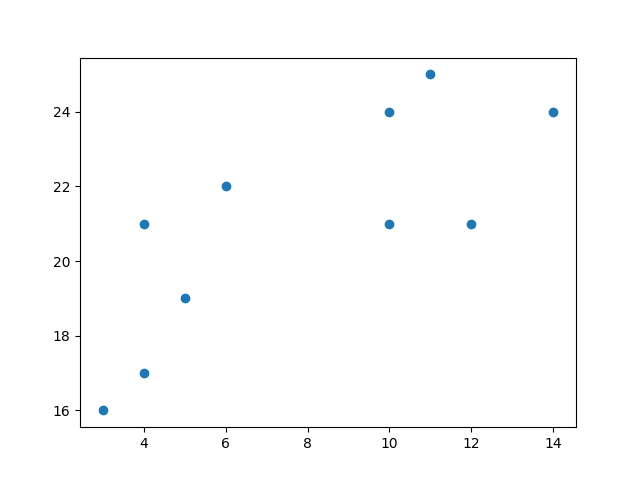

### To this
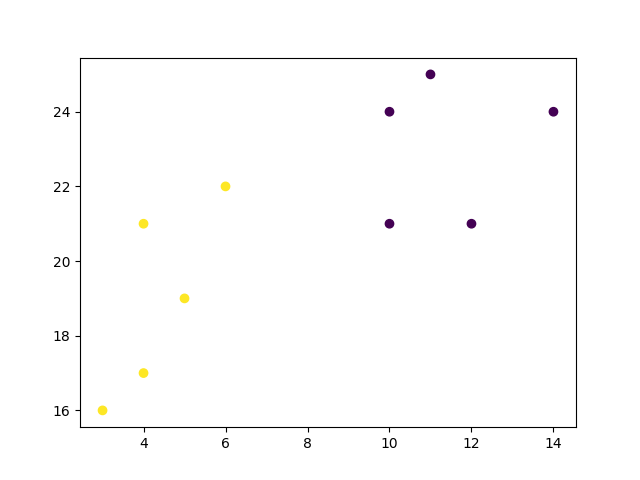

## Importing

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn_som.som import SOM


## Files Reading

In [3]:
# The location of the file - change it to the directory you extracted it
ds = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/29apr24/SalishSea_1d_20240429_20240429_grid_T.nc')
ds


<xarray.Dataset> Size: 230MB
Dimensions:       (time_counter: 1, y: 898, x: 398, deptht: 40)
Coordinates:
  * y             (y) int64 7kB 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * x             (x) int64 3kB 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 8B 2024-04-29T12:00:00
Data variables:
    sossheig      (time_counter, y, x) float32 1MB ...
    votemper      (time_counter, deptht, y, x) float32 57MB ...
    vosaline      (time_counter, deptht, y, x) float32 57MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 57MB ...
    e3t           (time_counter, deptht, y, x) float32 57MB ...
Attributes:
    name:         SalishSeaCast_1d_grid_T_20240429_20240429
    description:  Day-averaged physics tracers variables resampled from v2021...
    history:      2024-04-29 12:05 -07:00: Generated by reshapr.api.v1.extrac...
    Conventions:  CF-1.6

## Opening the dataset and its features

<xarray.Dataset> Size: 48MB
Dimensions:                 (time_counter: 76, y: 180, x: 80)
Coordinates:
  * time_counter            (time_counter) datetime64[ns] 608B 2007-02-15T12:...
  * y                       (y) int64 1kB 0 5 10 15 20 ... 875 880 885 890 895
  * x                       (x) int64 640B 0 5 10 15 20 ... 375 380 385 390 395
Data variables:
    Temperature_(0m-15m)    (time_counter, y, x) float32 4MB ...
    Temperature_(15m-100m)  (time_counter, y, x) float32 4MB ...
    Salinity_(0m-15m)       (time_counter, y, x) float32 4MB ...
    Salinity_(15m-100m)     (time_counter, y, x) float32 4MB ...
    Silicon                 (time_counter, y, x) float32 4MB ...
    Nitrate                 (time_counter, y, x) float32 4MB ...
    Ammonium                (time_counter, y, x) float32 4MB ...
    Diatom                  (time_counter, y, x) float32 4MB ...
    Flagellate              (time_counter, y, x) float32 4MB ...
    Microzooplankton        (time_counter, y, x) float32

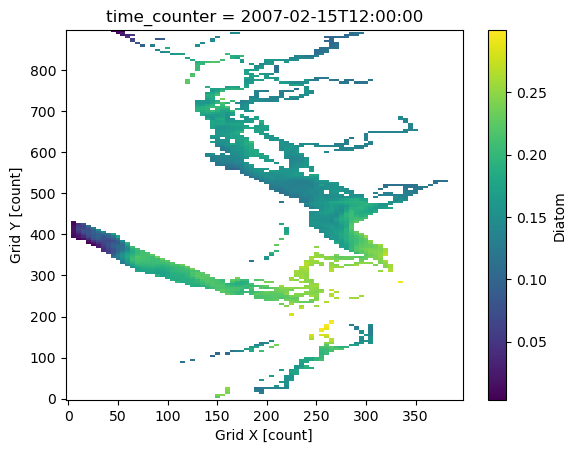

In [60]:
# Printing the features of the dataset
print(dataset)

# Plotting diatoms for the first day
dataset.Diatom[0].plot()

## Datasets Preparation

In [61]:
# Here I am packing all of them in one variable, named drivers

drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), 
    np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)']),
   
    # These 4 are tricky to flatten, but this is the right way
    np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter)),
    np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.month, len(dataset.x)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.day, len(dataset.x)*len(dataset.y))
    ])

# Removing of nans
indx = np.where(~np.isnan(drivers).any(axis=0))
drivers = drivers[:,indx[0]]

diat = np.ravel(dataset['Diatom'])
diat = diat[indx]

# Transpose to bring it to the format (samples, features)
drivers = drivers.transpose()

# 1st sample - grid box
drivers[0]

array([  8.52399445,   8.59896278,  28.21989632,  28.40815926,
         5.        , 150.        ,   2.        ,  15.        ])

## Training 

In [62]:
# First I define the model, with its transformers and regressor
model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
    transformers=[("temporal", OneHotEncoder(), [6,7]), ("spatial", OneHotEncoder(), [4,5])],remainder=StandardScaler()),
    MLPRegressor(alpha=0.001, learning_rate='adaptive', epsilon=1e-07, max_iter=500)), 
    transformer=QuantileTransformer())

# Loading the model in a bagging regressor and training it
regr = BaggingRegressor(model, n_estimators=10, n_jobs=-1).fit(drivers,diat)


## Testing

In [63]:
# Selecting one day in the future - the result will not look good, we do it just as an example
dataset = ds.sel(time_counter = slice('2023-4-20', '2023-4-20'))

# Same as before
drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), 
    np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)']),
    np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter)),
    np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.month, len(dataset.x)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.day, len(dataset.x)*len(dataset.y))
    ])

# Removing of nans
indx = np.where(~np.isnan(drivers).any(axis=0))
drivers = drivers[:,indx[0]]

diat = np.ravel(dataset['Diatom'])
diat = diat[indx]

# Transpose to bring it to the format (samples, features)
drivers = drivers.transpose()

drivers[0]

array([  8.46106243,   8.30505657,  28.68799591,  28.62046242,
         5.        , 150.        ,   4.        ,  20.        ])

## Prediction and evaluation

In [64]:
predicted = regr.predict(drivers)

print('The correlation coefficient is:', np.corrcoef(diat,predicted)[0,1])
print('The rmse is:', rmse(diat,predicted))

# Creating the map for the predicted values
indx2 = np.full((len(dataset.y)*len(dataset.x)),np.nan)
indx2[indx] = predicted
model = np.reshape(indx2,(len(dataset.y),len(dataset.x)))

# Preparation of the dataarray 
model = xr.DataArray(model,
    coords = {'y': dataset.y, 'x': dataset.x},
    dims = ['y','x'],
    attrs=dict(units="mmol m-2"))

The correlation coefficient is: 0.29228257240244504
The rmse is: 0.18540180344590446


## Scatter plot

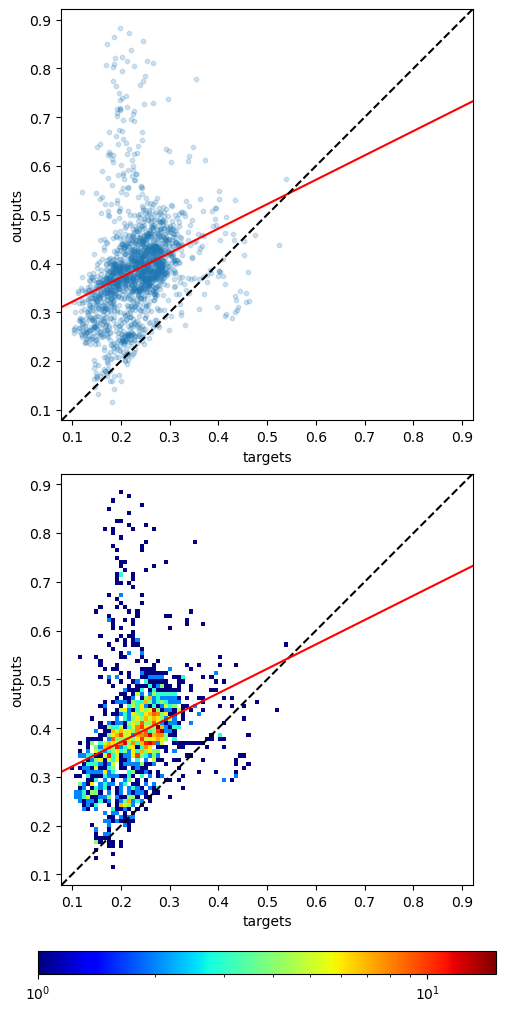

In [65]:
# compute slope m and intercept b
m, b = np.polyfit(diat, predicted, deg=1)

fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

ax[0].scatter(diat, predicted, alpha = 0.2, s = 10)

lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
    np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

# plot fitted y = m*x + b
ax[0].axline(xy1=(0, b), slope=m, color='r')

ax[0].set_xlabel('targets')
ax[0].set_ylabel('outputs')
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].set_aspect('equal')

ax[0].plot(lims, lims,linestyle = '--',color = 'k')

h = ax[1].hist2d(diat, predicted, bins=100, cmap='jet', 
    range=[lims,lims], cmin=0.1, norm='log')

ax[1].plot(lims, lims,linestyle = '--',color = 'k')

# plot fitted y = m*x + b
ax[1].axline(xy1=(0, b), slope=m, color='r')

ax[1].set_xlabel('targets')
ax[1].set_ylabel('outputs')
ax[1].set_aspect('equal')

fig.colorbar(h[3],ax=ax[1], location='bottom')

plt.show()

## Plotting

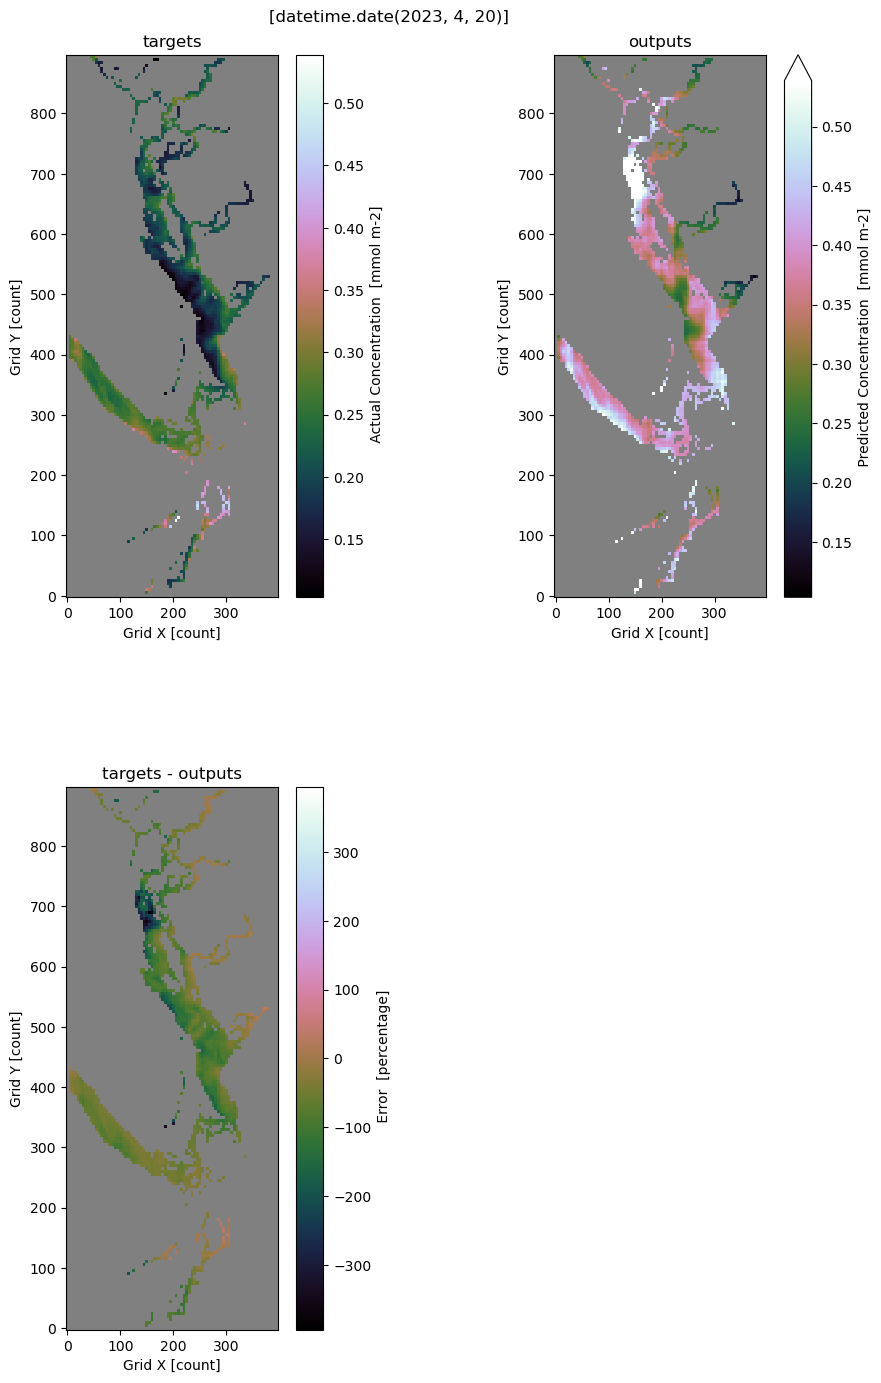

In [66]:
fig, ax = plt.subplots(2,2, figsize = (10,15))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

dataset.Diatom.plot(ax=ax[0,0], cmap=cmap, vmin = diat.min(), vmax =diat.max(), cbar_kwargs={'label':' Actual Concentration  [mmol m-2]'})
model.plot(ax=ax[0,1], cmap=cmap, vmin = diat.min(), vmax = diat.max(), cbar_kwargs={'label':' Predicted Concentration  [mmol m-2]'})
((dataset.Diatom-model) / dataset.Diatom * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': ' Error  [percentage]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.95, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0,0])
sa_vi.set_aspect(ax[0,1])
sa_vi.set_aspect(ax[1,0])

ax[0,0].title.set_text('targets')
ax[0,1].title.set_text('outputs')
ax[1,0].title.set_text('targets - outputs')
ax[1,1].axis('off')

fig.suptitle(dataset.time_counter.dt.date.values)

plt.show()


In [5]:
from skfda import datasets
import numpy as np

X, y = datasets.fetch_weather(return_X_y=True, as_frame=True)
fd = X.iloc[:, 0].values
fd_temperatures = fd.coordinates[0]
target = y.values


In [7]:
fd

FDataGrid(
    array([[[ -3.6,   5.2],
            [ -3.1,   5.8],
            [ -3.4,   3.9],
            ...,
            [ -3.2,   3. ],
            [ -2.8,   8.4],
            [ -4.2,   2.6]],
    
           [[ -4.4,   6. ],
            [ -4.2,   5.3],
            [ -5.3,   2.6],
            ...,
            [ -3.6,   7.8],
            [ -4.9,   5.9],
            [ -5.7,   2.8]],
    
           [[ -3.8,   5.3],
            [ -3.5,   5.2],
            [ -4.6,   2.1],
            ...,
            [ -3.4,   7.9],
            [ -3.3,   7.1],
            [ -4.8,   2.6]],
    
           ...,
    
           [[-23.3,   1.1],
            [-24. ,   0.9],
            [-24.4,   0.8],
            ...,
            [-23.5,   0.7],
            [-23.9,   0.7],
            [-24.5,   0.7]],
    
           [[-26.3,   0.8],
            [-27.1,   0.9],
            [-27.8,   0.8],
            ...,
            [-25.7,   0.4],
            [-24. ,   0.3],
            [-24.8,   0.8]],
    
           [[